<a href="https://colab.research.google.com/github/srilakshmi-saladi/NLP/blob/main/esemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow tensorflow-addons scikit-learn scipy matplotlib seaborn pandas numpy

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import cohen_kappa_score, confusion_matrix
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt
# import seaborn as sns

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzipped ✅
TF  : 2.19.0
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ /content/idrid_grading/B. Disease Grading/1. Original Images/a. Training Set
✅ /content/idrid_grading/B. Disease Grading/1. Original Images/b. Testing Set
✅ /content/idrid_grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv
✅ /content/idrid_grading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv
BATCH=16  IMG=456  FINE_TUNE_LAST_N=60
Train: 413 | Test: 103
Train dist:
 label
0    134
1     20
2    136
3     74
4     49
Name: count, dtype: int64
Test  dist:
 label
0    34
1     5
2    32
3    19
4    13
Name: count, dtype: int64
Running speed test...
  image : (16, 456, 456, 3)  dr: (16, 5)
  First batch: 6.1s  (should be <5s ✅)
Class weights tensor: [0.6164179 4.13      0.6073529 1.1162162 1.6857

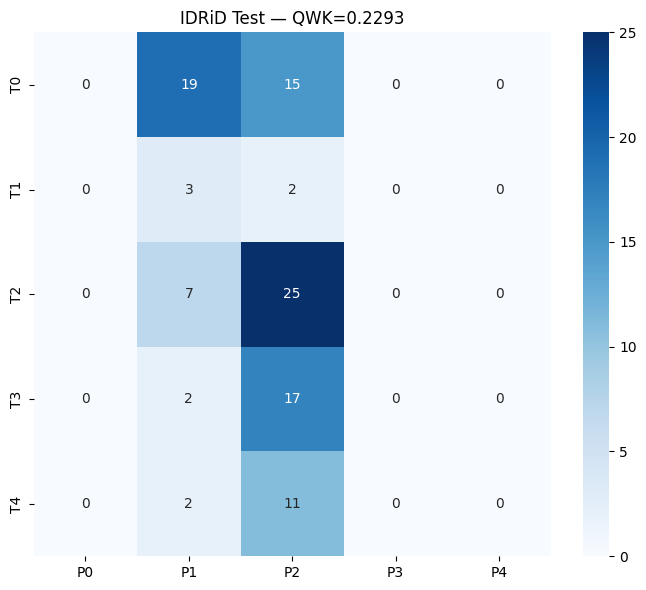


✅ FINAL QWK: 0.2293
   Thresholds: [0.51230469 1.40507812 2.62792969 3.46308594]
   Config saved: /content/inference_config.json


In [2]:
# ============================================================
# CELL 1 — Install
# ============================================================
!pip install -q scikit-learn scipy matplotlib seaborn pandas numpy


# ============================================================
# CELL 2 — Mount Drive + unzip
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, glob, sys, time

ZIP_PATH = "/content/drive/MyDrive/fundusDatasets/DR Grading/B_Disease Grading.zip"
OUT_DIR  = "/content/idrid_grading"
os.makedirs(OUT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(OUT_DIR)

print("Unzipped ✅", flush=True)


# ============================================================
# CELL 3 — Imports
# ============================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import json

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Force GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("TF  :", tf.__version__, flush=True)
print("GPU :", gpus, flush=True)


# ============================================================
# CELL 4 — Paths
# ============================================================
ROOT          = "/content/idrid_grading/B. Disease Grading"
TRAIN_IMG_DIR = ROOT + "/1. Original Images/a. Training Set"
TEST_IMG_DIR  = ROOT + "/1. Original Images/b. Testing Set"
TRAIN_CSV     = ROOT + "/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
TEST_CSV      = ROOT + "/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

for p in [TRAIN_IMG_DIR, TEST_IMG_DIR, TRAIN_CSV, TEST_CSV]:
    print("✅" if os.path.exists(p) else "❌ MISSING", p, flush=True)


# ============================================================
# CELL 5 — Config
# ============================================================
NUM_CLASSES       = 5
NUM_EDEMA_CLASSES = 3
BATCH_SIZE        = 16     # 15GB GPU can handle 16 at 456px
IMG_SIZE          = 456
FINE_TUNE_LAST_N  = 60
N_TTA             = 10
NUM_ENSEMBLE      = 3

print(f"BATCH={BATCH_SIZE}  IMG={IMG_SIZE}  FINE_TUNE_LAST_N={FINE_TUNE_LAST_N}", flush=True)


# ============================================================
# CELL 6 — Load CSVs
# ============================================================
train_labels = pd.read_csv(TRAIN_CSV)
test_labels  = pd.read_csv(TEST_CSV)

train_labels.columns = train_labels.columns.str.strip()
test_labels.columns  = test_labels.columns.str.strip()
train_labels = train_labels.loc[:, ~train_labels.columns.str.startswith("Unnamed")]
test_labels  = test_labels.loc[:,  ~test_labels.columns.str.startswith("Unnamed")]

IMAGE_COL = "Image name"
GRADE_COL = "Retinopathy grade"
EDEMA_COL = "Risk of macular edema"

def build_df(labels_df, img_dir):
    df = labels_df.copy()
    df["filename"]    = df[IMAGE_COL].apply(
        lambda x: str(x).strip() + ".jpg"
        if not str(x).strip().endswith(".jpg") else str(x).strip()
    )
    df["label"]       = df[GRADE_COL].astype(int)
    df["edema_label"] = df[EDEMA_COL].astype(int) if EDEMA_COL in df.columns else 0
    df["path"]        = df["filename"].apply(lambda x: os.path.join(img_dir, x))
    df = df[df["path"].apply(os.path.exists)].reset_index(drop=True)
    return df[["path", "label", "edema_label"]]

train_df = build_df(train_labels, TRAIN_IMG_DIR)
test_df  = build_df(test_labels,  TEST_IMG_DIR)

print(f"Train: {len(train_df)} | Test: {len(test_df)}", flush=True)
print("Train dist:\n", train_df["label"].value_counts().sort_index(), flush=True)
print("Test  dist:\n", test_df["label"].value_counts().sort_index(),  flush=True)


# ============================================================
# CELL 7 — Ben Graham preprocessing (FAST version)
# Uses resize-based blur — avoids slow depthwise_conv2d compilation
# ============================================================
def ben_graham_preprocess(image):
    image   = tf.cast(image, tf.float32)
    # Cheap blur: downsample 10x then upsample back
    small   = tf.image.resize(image, [IMG_SIZE // 10, IMG_SIZE // 10])
    blurred = tf.image.resize(small,  [IMG_SIZE, IMG_SIZE])
    # Local contrast enhancement (Ben Graham formula)
    image   = image * 4.0 + blurred * (-4.0) + 128.0
    image   = tf.clip_by_value(image, 0.0, 255.0) / 255.0
    return image


# ============================================================
# CELL 8 — Augmentation
# ============================================================
def strong_augment(image, dr_label, edema_label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    k     = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    frac  = tf.random.uniform([], 0.85, 1.0)
    ch    = tf.cast(tf.cast(IMG_SIZE, tf.float32) * frac, tf.int32)
    image = tf.image.random_crop(image, [ch, ch, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, dr_label, edema_label


# ============================================================
# CELL 9 — MixUp
# ============================================================
def mixup(ds):
    def _mix(b1, b2):
        img1, dr1, ed1 = b1
        img2, dr2, ed2 = b2
        lam    = tf.random.stateless_uniform([], seed=(SEED, 0), minval=0.0, maxval=1.0)
        lam    = tf.maximum(lam, 1.0 - lam)
        return lam*img1+(1-lam)*img2, lam*dr1+(1-lam)*dr2, lam*ed1+(1-lam)*ed2
    return tf.data.Dataset.zip(
        (ds, ds.shuffle(512, seed=SEED))
    ).map(_mix, num_parallel_calls=tf.data.AUTOTUNE)


# ============================================================
# CELL 10 — Dataset builder + speed test
# ============================================================
def load_and_preprocess(path, dr_label, edema_label):
    raw      = tf.io.read_file(path)
    image    = tf.image.decode_jpeg(raw, channels=3)
    image    = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image    = ben_graham_preprocess(image)
    dr_oh    = tf.one_hot(tf.cast(dr_label,    tf.int32), NUM_CLASSES)
    edema_oh = tf.one_hot(tf.cast(edema_label, tf.int32), NUM_EDEMA_CLASSES)
    return image, dr_oh, edema_oh


def make_ds(df, training=False, use_mixup=False):
    ds = tf.data.Dataset.from_tensor_slices((
        df["path"].values,
        df["label"].values.astype(np.int32),
        df["edema_label"].values.astype(np.int32)
    ))
    if training:
        ds = ds.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(strong_augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=training)
    if training and use_mixup:
        ds = mixup(ds)
    ds = ds.map(
        lambda img, dr, ed: (img, {"dr_output": dr, "edema_output": ed}),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return ds.prefetch(tf.data.AUTOTUNE)


# Speed test — should complete in <5s
print("Running speed test...", flush=True)
t0 = time.time()
_ds = make_ds(train_df, training=True, use_mixup=True)
for _x, _y in _ds.take(1):
    print(f"  image : {_x.shape}  dr: {_y['dr_output'].shape}", flush=True)
print(f"  First batch: {time.time()-t0:.1f}s  (should be <5s ✅)", flush=True)


# ============================================================
# CELL 11 — Losses (with built-in class weighting)
# ============================================================
def get_class_weights():
    cw = compute_class_weight("balanced", classes=np.arange(NUM_CLASSES),
                               y=train_df["label"].values)
    return tf.cast(cw, tf.float32)   # shape (5,)

CLASS_WEIGHTS_TENSOR = get_class_weights()
print("Class weights tensor:", CLASS_WEIGHTS_TENSOR.numpy(), flush=True)

def ordinal_focal_loss(y_true, y_pred, gamma=2.0, label_smoothing=0.1):
    nc      = tf.cast(tf.shape(y_true)[-1], tf.float32)
    y_s     = y_true * (1.0 - label_smoothing) + label_smoothing / nc
    ce      = -y_s * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
    pt      = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)
    fce     = ((1.0 - pt) ** gamma) * tf.reduce_sum(ce, axis=-1)
    idx     = tf.cast(tf.range(tf.shape(y_true)[-1]), tf.float32)
    penalty = tf.abs(
        tf.reduce_sum(y_true * idx, axis=-1) -
        tf.reduce_sum(y_pred * idx, axis=-1)
    )
    # Apply per-sample class weight based on true label
    true_class  = tf.argmax(y_true, axis=-1)                      # (B,)
    sample_w    = tf.gather(CLASS_WEIGHTS_TENSOR, true_class)      # (B,)
    loss        = (fce + 0.5 * penalty) * sample_w
    return tf.reduce_mean(loss)

def edema_focal_loss(y_true, y_pred, gamma=2.0):
    ce  = -y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
    pt  = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)
    return tf.reduce_mean(((1.0 - pt) ** gamma) * tf.reduce_sum(ce, axis=-1))

print("Losses defined ✅", flush=True)



# ============================================================
# CELL 12 — Model
# ============================================================
def build_model(dropout=0.4):
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base   = keras.applications.EfficientNetB5(include_top=False, weights="imagenet")
    x      = keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x      = base(x, training=False)
    x      = layers.GlobalAveragePooling2D()(x)
    x      = layers.BatchNormalization()(x)
    x      = layers.Dropout(dropout)(x)
    shared = layers.Dense(512, activation="relu")(x)
    shared = layers.Dropout(dropout / 2)(shared)
    dr     = layers.Dense(256, activation="relu")(shared)
    dr     = layers.Dropout(dropout / 2)(dr)
    dr     = layers.Dense(NUM_CLASSES,       activation="softmax", name="dr_output")(dr)
    ed     = layers.Dense(128, activation="relu")(shared)
    ed     = layers.Dense(NUM_EDEMA_CLASSES, activation="softmax", name="edema_output")(ed)
    return keras.Model(inputs, {"dr_output": dr, "edema_output": ed}), base

# Test build
print("Building model...", flush=True)
_m, _b = build_model()
print(f"  Params: {_m.count_params():,}", flush=True)
del _m, _b
print("Model OK ✅", flush=True)


# ============================================================
# CELL 13 — QWK Callback
# ============================================================
class QWKCallback(keras.callbacks.Callback):
    def __init__(self, val_ds, save_path="best.keras"):
        super().__init__()
        self.val_ds    = val_ds
        self.save_path = save_path
        self.best_qwk  = -1.0
        self.history   = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_true, y_pred = [], []
        for xb, yd in self.val_ds:
            out  = self.model.predict(xb, verbose=0)
            drp  = out["dr_output"] if isinstance(out, dict) else out
            y_true.extend(np.argmax(yd["dr_output"].numpy(), axis=1))
            y_pred.extend(np.argmax(drp, axis=1))

        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        self.history.append(qwk)

        def f(v): return f"{v:.4f}" if isinstance(v, float) else "?"
        print(
            f"  Ep{epoch+1:02d} | "
            f"loss={f(logs.get('loss'))} "
            f"val_loss={f(logs.get('val_loss'))} | "
            f"dr_acc={f(logs.get('dr_output_accuracy'))} "
            f"val_dr_acc={f(logs.get('val_dr_output_accuracy'))} | "
            f"QWK={qwk:.4f}",
            flush=True
        )
        if qwk > self.best_qwk:
            self.best_qwk = qwk
            self.model.save(self.save_path)
            print(f"  ✅ Best QWK={qwk:.4f} saved → {self.save_path}", flush=True)

# ============================================================
# CELL 14 — train_member (class_weight removed from m.fit)
# ============================================================
CUSTOM_OBJ = {"ordinal_focal_loss": ordinal_focal_loss,
              "edema_focal_loss"  : edema_focal_loss}

def train_member(seed, save_path):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    print(f"\n{'='*60}", flush=True)
    print(f"  seed={seed}  →  {save_path}", flush=True)
    print(f"{'='*60}", flush=True)

    tr_ds = make_ds(train_df, training=True,  use_mixup=True)
    va_ds = make_ds(test_df,  training=False)
    m, b  = build_model()

    # ── Stage A: head only ──────────────────────────────────
    print("\n--- Stage A: head only ---", flush=True)
    b.trainable = False
    m.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={"dr_output": ordinal_focal_loss, "edema_output": edema_focal_loss},
        loss_weights={"dr_output": 1.0, "edema_output": 0.3},
        metrics={"dr_output": "accuracy"}
    )
    qwk_a = QWKCallback(va_ds, save_path + "_stageA.keras")
    m.fit(
        tr_ds, validation_data=va_ds, epochs=12,
        # ← NO class_weight here (not supported for multi-output)
        #   class weighting is handled inside ordinal_focal_loss
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                          restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                              patience=2, min_lr=1e-6),
            qwk_a,
        ], verbose=0
    )
    print(f"Stage A done | best QWK={qwk_a.best_qwk:.4f}", flush=True)

    # ── Stage B: fine-tune ──────────────────────────────────
    print("\n--- Stage B: fine-tune ---", flush=True)
    b.trainable = True
    for layer in b.layers[:-FINE_TUNE_LAST_N]:
        layer.trainable = False
    for layer in b.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    print(f"  Trainable layers: {sum(l.trainable for l in b.layers)}/{len(b.layers)}", flush=True)

    steps  = int(np.ceil(len(train_df) / BATCH_SIZE)) * 30
    lr_cos = keras.optimizers.schedules.CosineDecay(1e-4, steps, alpha=1e-6)
    m.compile(
        optimizer=keras.optimizers.Adam(lr_cos),
        loss={"dr_output": ordinal_focal_loss, "edema_output": edema_focal_loss},
        loss_weights={"dr_output": 1.0, "edema_output": 0.3},
        metrics={"dr_output": "accuracy"}
    )
    qwk_b = QWKCallback(va_ds, save_path)
    m.fit(
        tr_ds, validation_data=va_ds, epochs=30,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=8,
                                          restore_best_weights=True),
            qwk_b,
        ], verbose=0
    )
    print(f"Stage B done | best QWK={qwk_b.best_qwk:.4f}", flush=True)
    print(f"QWK history: {[round(q,3) for q in qwk_b.history]}", flush=True)



# ============================================================
# CELL 15 — Train all 3 ensemble members
# ============================================================
ensemble_paths = []
for i, seed in enumerate([42, 123, 777]):
    p = f"/content/ensemble_{i}_seed{seed}.keras"
    train_member(seed=seed, save_path=p)
    ensemble_paths.append(p)
    print(f"\n✅ Member {i+1}/3 complete\n", flush=True)

print("All models trained:", ensemble_paths, flush=True)



# ============================================================
# CELL 16 — TTA + ensemble
# ============================================================
tta_aug = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])

def predict_tta(model_path, dataset, n_tta=N_TTA):
    m = keras.models.load_model(model_path, custom_objects=CUSTOM_OBJ)
    y_true = np.concatenate([
        np.argmax(yd["dr_output"].numpy(), axis=1)
        for _, yd in dataset
    ])
    all_probs = []
    for t in range(n_tta):
        probs = []
        for xb, _ in dataset:
            xin = tta_aug(xb, training=True) if t > 0 else xb
            out = m.predict(xin, verbose=0)
            probs.append(out["dr_output"] if isinstance(out, dict) else out)
        all_probs.append(np.concatenate(probs, axis=0))
        print(f"  TTA {t+1}/{n_tta}", flush=True)
    return y_true, np.mean(all_probs, axis=0)

val_ds_final = make_ds(test_df, training=False)
member_probs = []
for i, path in enumerate(ensemble_paths):
    print(f"\nMember {i+1}/{len(ensemble_paths)}: {path}", flush=True)
    y_true, probs = predict_tta(path, val_ds_final)
    member_probs.append(probs)

avg_probs = np.mean(member_probs, axis=0)
print(f"Ensemble probs shape: {avg_probs.shape} ✅", flush=True)


# ============================================================
# CELL 17 — Threshold optimisation
# ============================================================
soft_score = avg_probs @ np.arange(NUM_CLASSES, dtype=np.float32)

def neg_qwk(thr):
    p = np.digitize(soft_score, np.sort(thr)).clip(0, NUM_CLASSES-1)
    return -cohen_kappa_score(y_true, p, weights="quadratic")

res      = minimize(neg_qwk, x0=[0.5, 1.5, 2.5, 3.5], method="Nelder-Mead",
                    options={"maxiter": 5000, "xatol": 1e-5})
best_thr = np.sort(res.x)
y_opt    = np.digitize(soft_score, best_thr).clip(0, NUM_CLASSES-1)
y_argmax = np.argmax(avg_probs, axis=1)
print("Optimised thresholds:", best_thr, flush=True)


# ============================================================
# CELL 18 — Final report
# ============================================================
def report(yt, yp, title):
    acc = (yt == yp).mean()
    qwk = cohen_kappa_score(yt, yp, weights="quadratic")
    sev = np.mean(np.abs(yt - yp) >= 2)
    print(f"\n{'='*55}\n  {title}\n{'='*55}")
    print(f"  Accuracy        : {acc:.4f}")
    print(f"  QWK             : {qwk:.4f}")
    print(f"  Severe err (≥2) : {sev:.4f}")
    return qwk

report(y_true, y_argmax, "Ensemble + TTA  (argmax)")
final_qwk = report(y_true, y_opt, "Ensemble + TTA + Threshold Opt  ← FINAL")

cm = confusion_matrix(y_true, y_opt)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"P{i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"T{i}" for i in range(NUM_CLASSES)])
plt.title(f"IDRiD Test — QWK={final_qwk:.4f}")
plt.tight_layout()
plt.savefig("/content/confusion_matrix.png", dpi=150)
plt.show()


# ============================================================
# CELL 19 — Save inference config
# ============================================================
cfg = {"ensemble_paths": ensemble_paths,
       "thresholds": best_thr.tolist(),
       "img_size": IMG_SIZE,
       "num_classes": NUM_CLASSES,
       "n_tta": N_TTA}
with open("/content/inference_config.json", "w") as f:
    json.dump(cfg, f, indent=2)

print(f"\n✅ FINAL QWK: {final_qwk:.4f}", flush=True)
print(f"   Thresholds: {best_thr}", flush=True)
print(f"   Config saved: /content/inference_config.json", flush=True)